In [1]:
import scanpy as sc
import omicverse as ov

ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.8, Tutorials: https://omicverse.readthedocs.io/
Dependency error: The 'bioservices' distribution was not found and is required by the application


In [2]:
# 定义您的分组列和细胞类型注释列名称
GROUP_COL = "group"  # 替换为您的实际分组列名，例如 'ctrl' 和 'stim'
SIMPLE_COL = "patients_organ"
ANNO_COL = "celltypist"
STIM = "LCL"
CTROL = "CCL"

In [3]:
# 设置参数
import matplotlib as mpl

mpl.rcParams["pdf.fonttype"] = 42  # 保留字体
sc.settings.verbosity = 4  # 输出细节
sc._settings.ScanpyConfig.n_jobs = -1  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

In [97]:
adata = sc.read("results/adata_raw_CCL_LCL/anndata_annotation_harmony_celltypist.h5ad")

In [98]:
adata.obs[ANNO_COL].unique()

['T cells', 'Macrophages', 'Mast cells', 'DC', 'pDC', 'B cells', 'ILC', 'Plasma cells']
Categories (8, object): ['B cells', 'DC', 'ILC', 'Macrophages', 'Mast cells', 'Plasma cells', 'T cells', 'pDC']

In [99]:
adata = adata[adata.obs[ANNO_COL] == "Macrophages"].copy()

In [100]:
%%time
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)
adata

Begin robust gene identification
After filtration, 1940/2000 genes are kept.     Among 1940 genes, 1821 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 0.261059045791626 seconds.
End of size normalization: shiftlog and HVGs selection pearson
CPU times: user 1.38 s, sys: 208 ms, total: 1.59 s
Wall time: 327 ms


AnnData object with n_obs × n_vars = 5110 × 1821
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leiden_1', 'leiden_2', 'celltypist_cell_label_fine',

In [101]:
ov.pp.scale(adata)
ov.pp.pca(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    ... clipping at max_value 10
computing PCA
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PCs', the loadings (adata.varm)
    'pca_variance', the variance / eigenvalues (adata.uns['pca'])
    'pca_variance_ratio', the variance ratio (adata.uns['pca'])


In [102]:
# ov.pp.umap(adata)

<AxesSubplot: title={'center': 'patients_organ'}, xlabel='X_umap1', ylabel='X_umap2'>

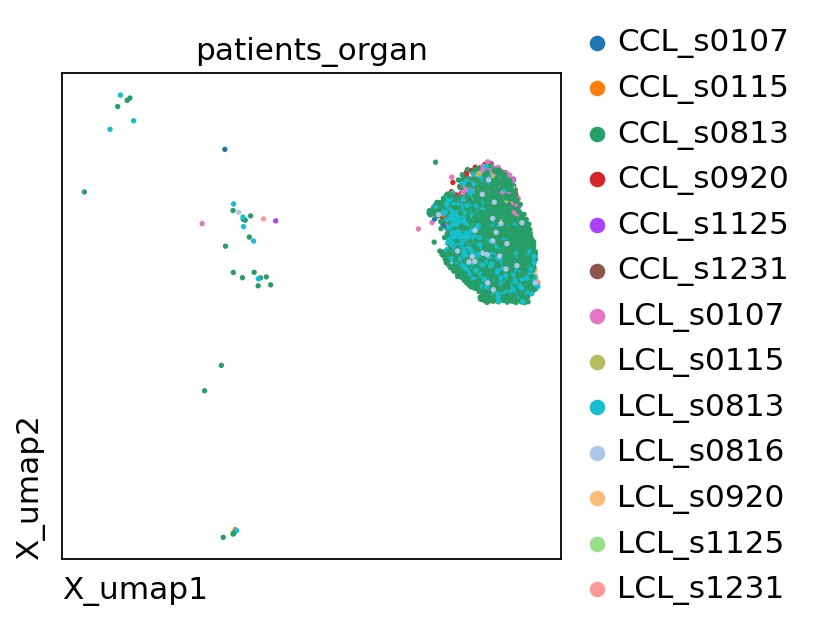

In [103]:
import matplotlib.pyplot as plt
from matplotlib import patheffects

fig, ax = plt.subplots(figsize=(4, 4))
ov.pl.embedding(
    adata,
    basis="X_umap",
    color=[SIMPLE_COL],
    # frameon="small",
    # title="Celltypes",
    # legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    # size=10,
    ax=ax,
    # legend_loc=True,
    add_outline=False,
    # add_outline=True,
    outline_color="black",
    outline_width=1,
    show=False,
)

- 初始化模型

In [11]:
import numpy as np
## Initialize the cnmf object that will be used to run analyses
cnmf_obj = ov.single.cNMF(adata,components=np.arange(3,20), n_iter=200, seed=123, num_highvar_genes=2000,
                          output_dir='example_dg/cNMF', name='dg_cNMF')

normalizing counts per cell
    finished (0:00:00)


In [12]:
## Specify that the jobs are being distributed over a single worker (total_workers=1) and then launch that worker
cnmf_obj.factorize(worker_i=0, total_workers=20)

170it [11:56,  4.21s/it]


In [13]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=3.
Missing file: example_dg/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_3.iter_1.df.npz. Skipping.
Missing file: example_dg/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_3.iter_2.df.npz. Skipping.
Missing file: example_dg/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_3.iter_3.df.npz. Skipping.
Missing file: example_dg/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_3.iter_4.df.npz. Skipping.
Missing file: example_dg/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_3.iter_5.df.npz. Skipping.
Missing file: example_dg/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_3.iter_6.df.npz. Skipping.
Missing file: example_dg/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_3.iter_7.df.npz. Skipping.
Missing file: example_dg/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_3.iter_8.df.npz. Skipping.
Missing file: example_dg/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_3.iter_9.df.npz. Skipping.
Missing file: example_dg/cNMF/dg_cNMF/cnmf_tmp/dg_cNMF.spectra.k_3.iter_10.df.npz. Skipping.
Missing file: example_dg/cNMF/dg_cNMF/cnmf_tm

- Compute the stability and error at each choice of K to see if a clear choice jumps out

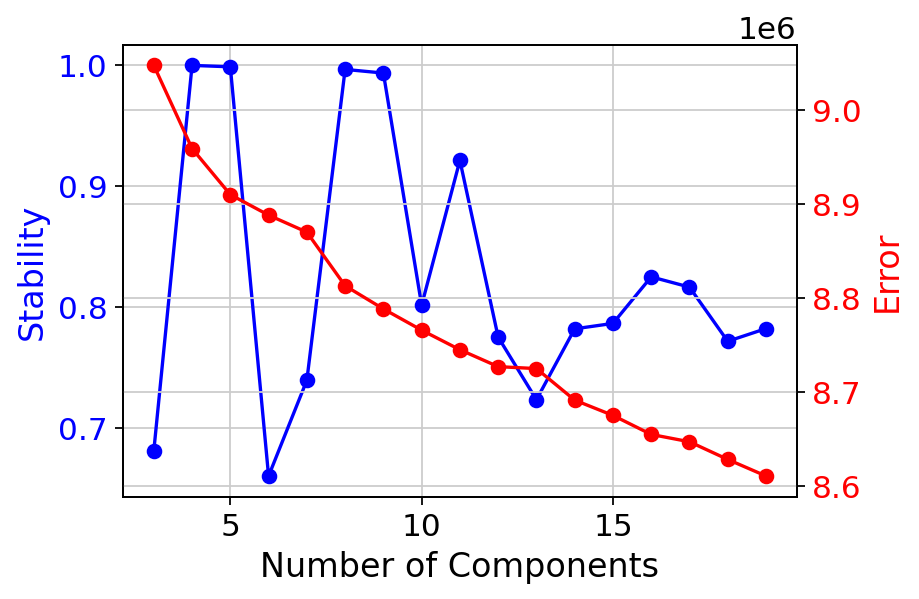

In [162]:
cnmf_obj.k_selection_plot(close_fig=False)

In this range, K=7 gave the most stable solution so we will begin by looking at that.

The next step computes the consensus solution for a given choice of K. We first run it without any outlier filtering to see what that looks like. Setting the density threshold to anything >= 2.00 (the maximum possible distance between two unit vectors) ensures that nothing will be filtered.

In [61]:
selected_K = 8
density_threshold = 2.00

In [62]:
!pip install fastcluster

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


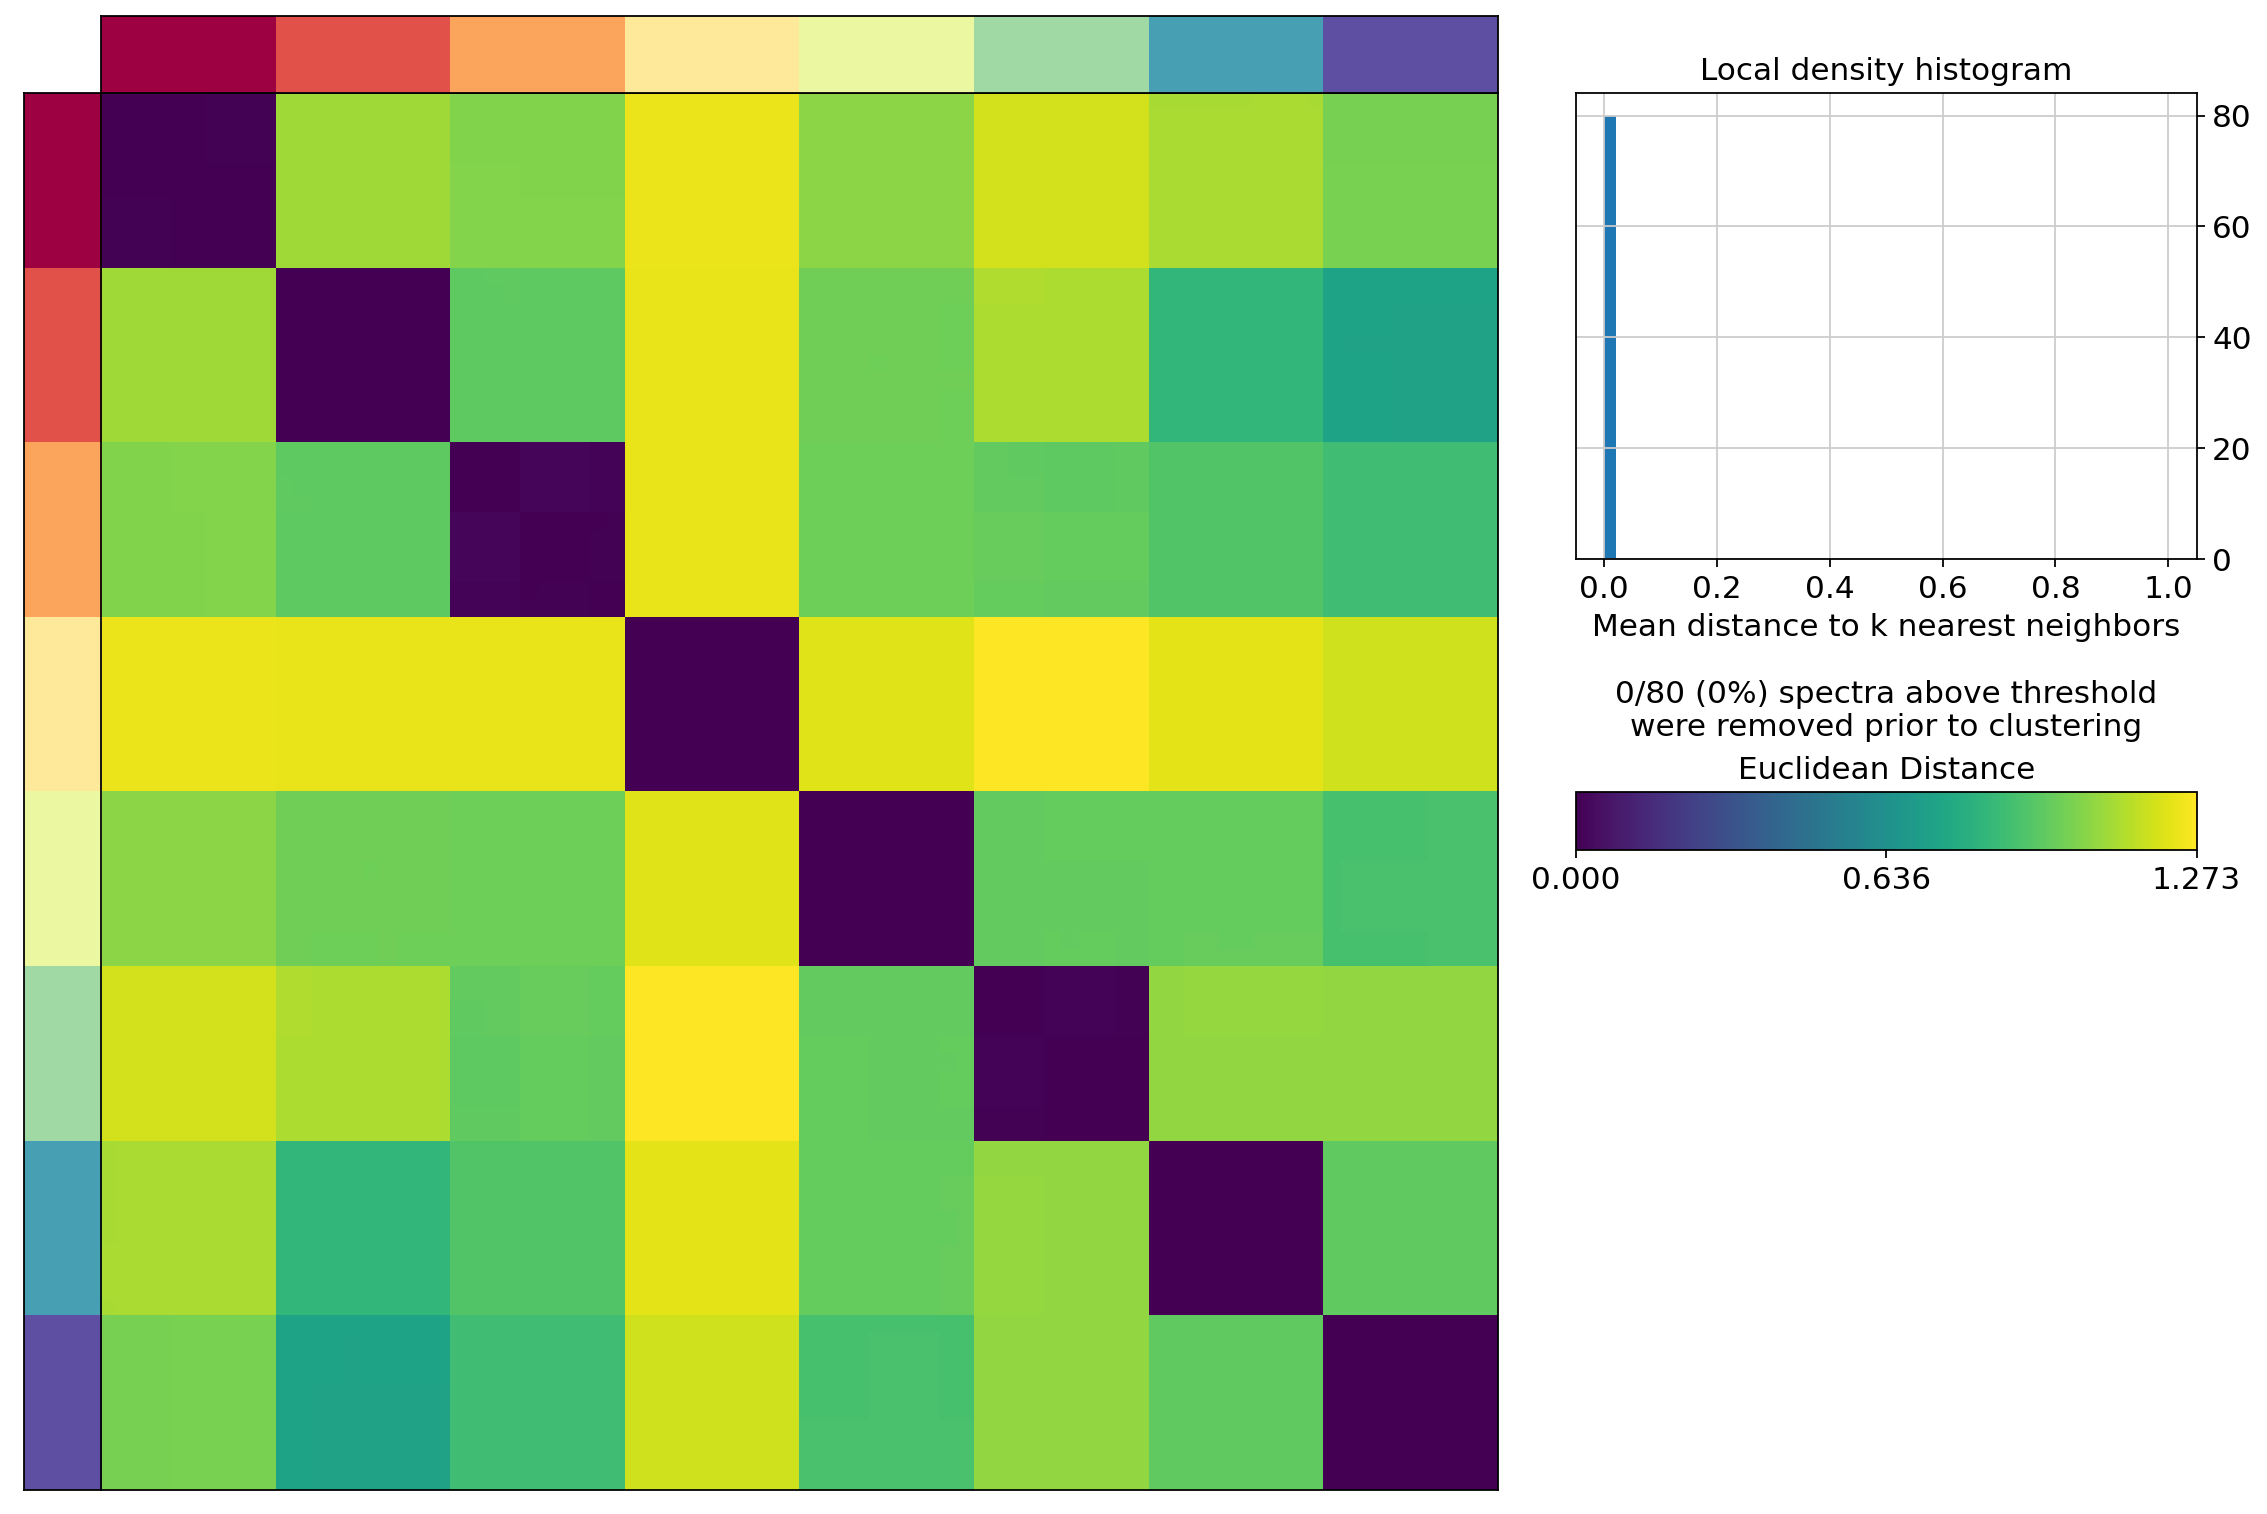

In [63]:
cnmf_obj.consensus(
    k=selected_K,
    density_threshold=density_threshold,
    show_clustering=True,
    close_clustergram_fig=False,
)

In [64]:
density_threshold = 0.10

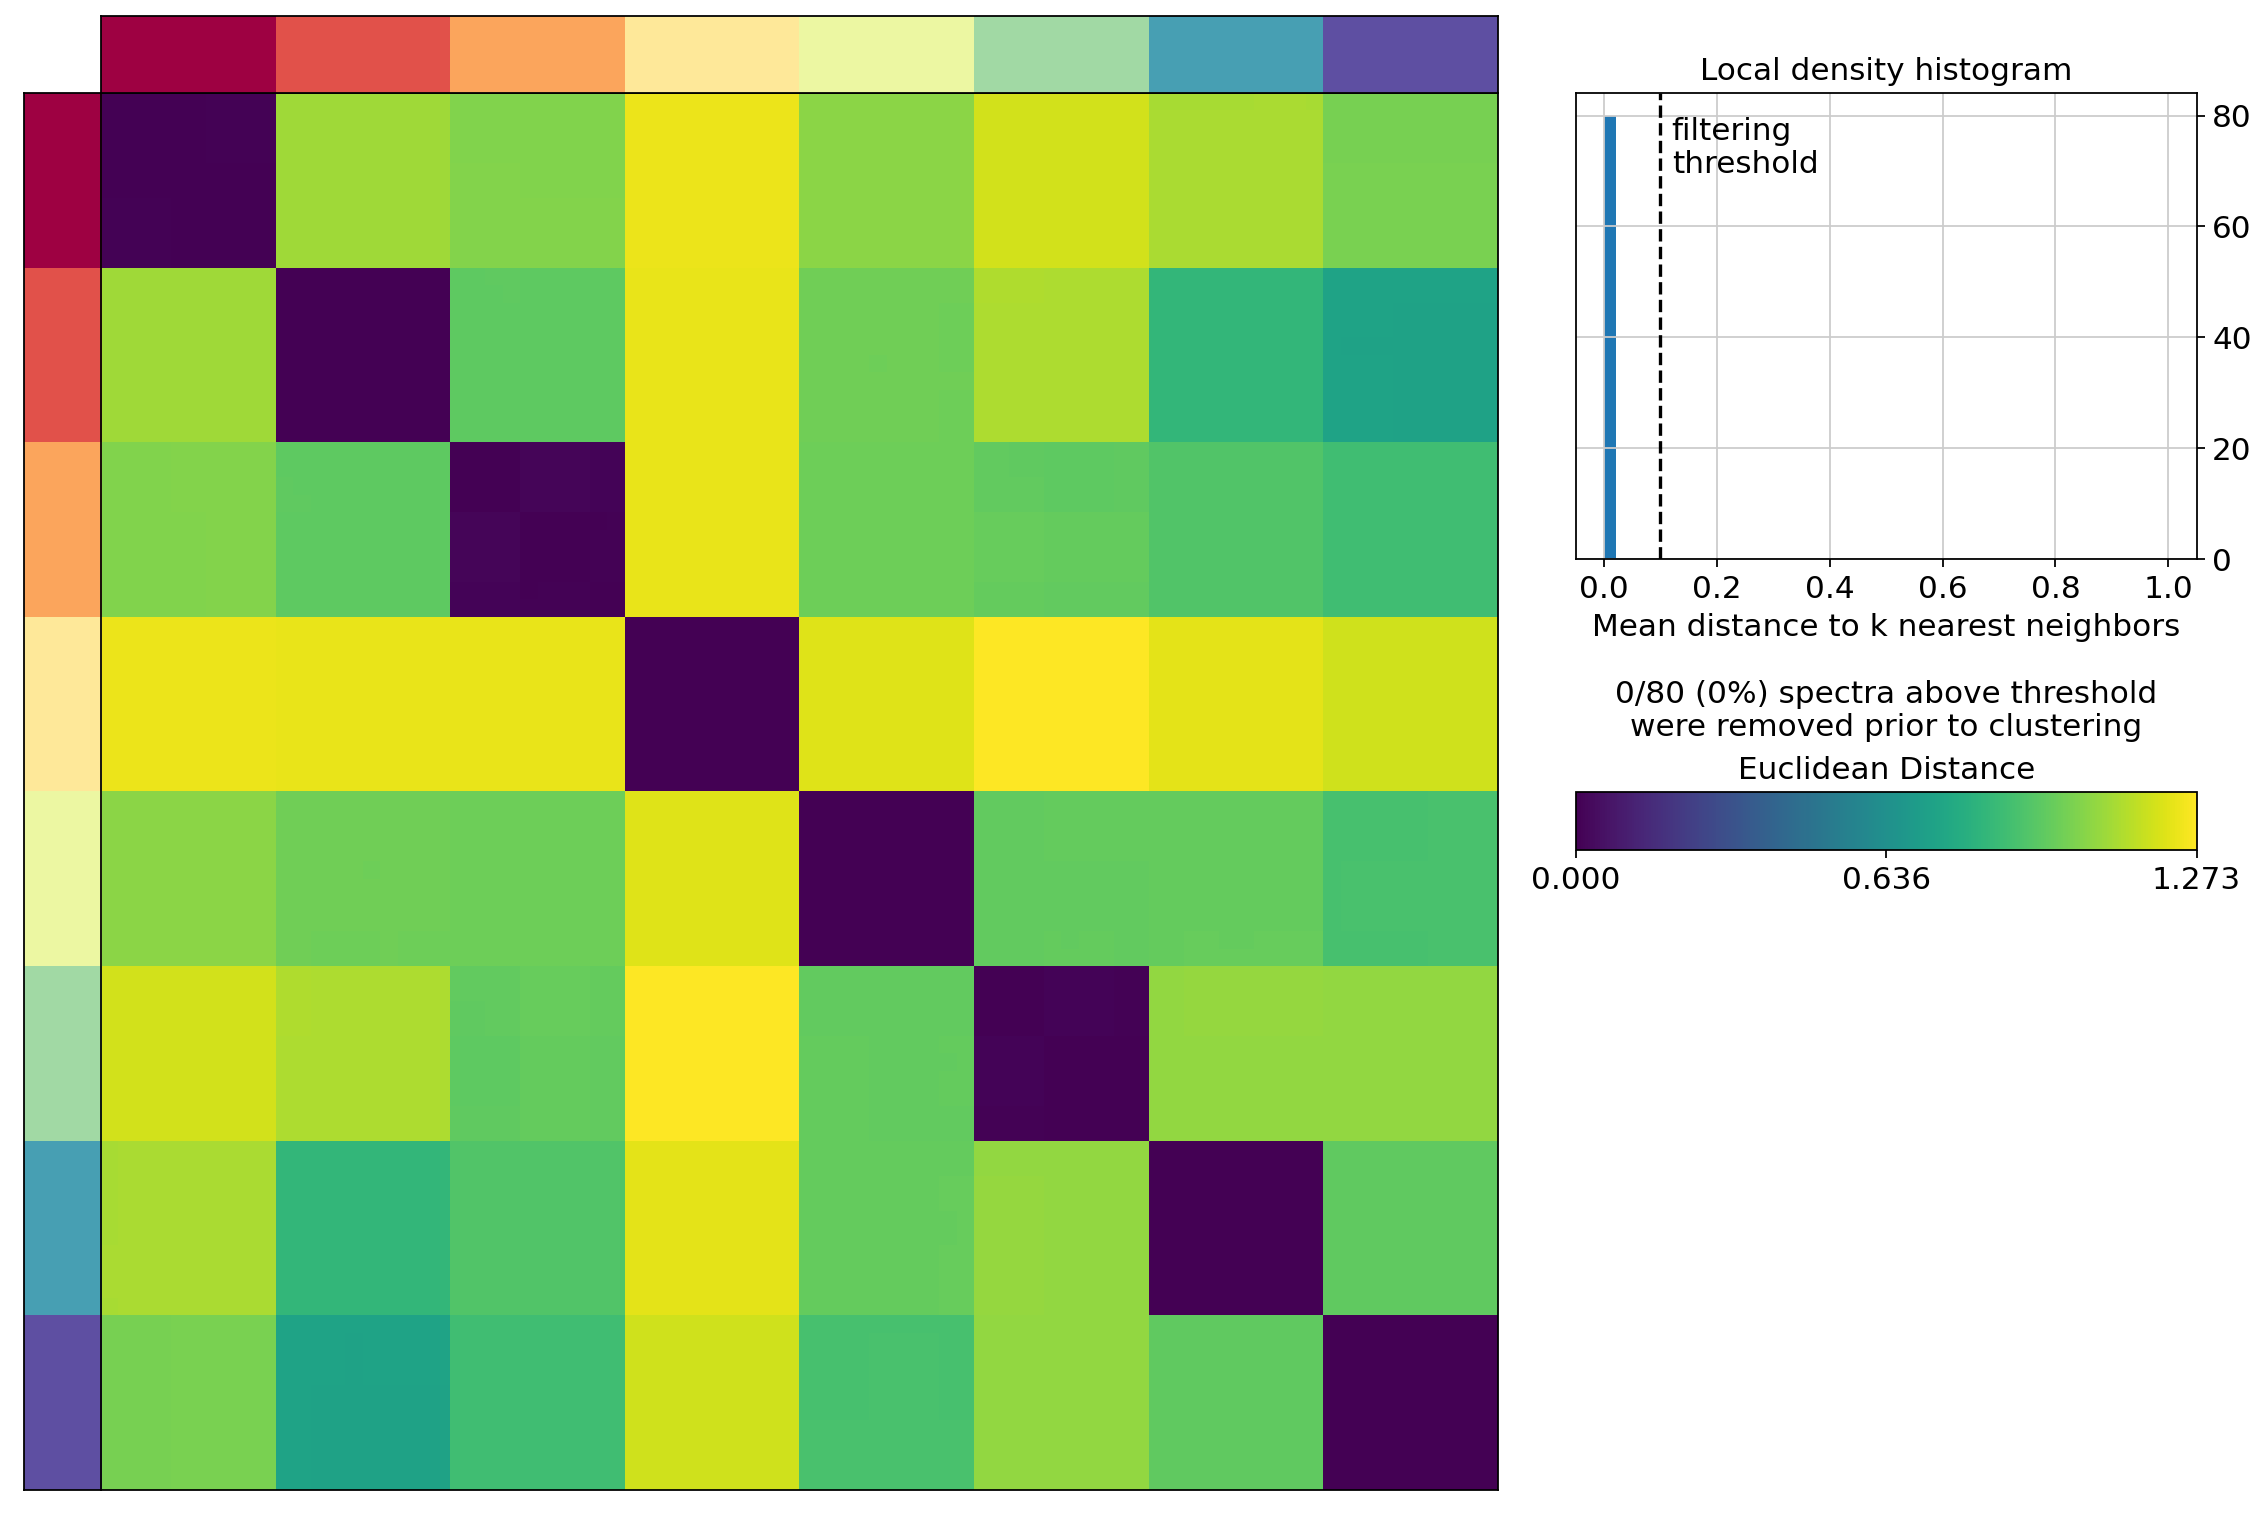

In [65]:

cnmf_obj.consensus(
    k=selected_K,
    density_threshold=density_threshold,
    show_clustering=True,
    close_clustergram_fig=False,
)

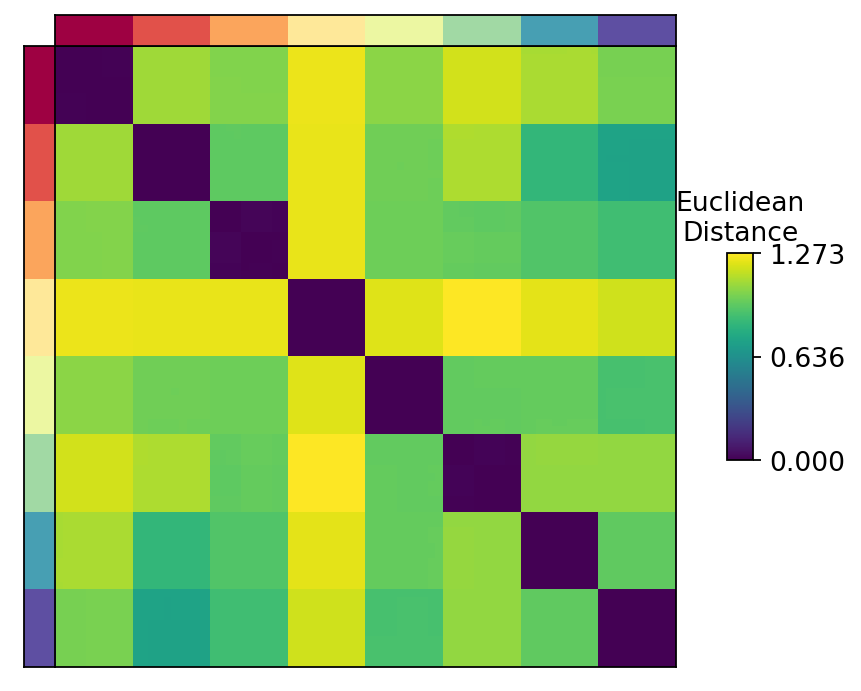

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patheffects

from matplotlib import gridspec
import matplotlib.pyplot as plt

width_ratios = [0.2, 4, 0.5, 10, 1]
height_ratios = [0.2, 4]
fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))
gs = gridspec.GridSpec(
    len(height_ratios),
    len(width_ratios),
    fig,
    0.01,
    0.01,
    0.98,
    0.98,
    height_ratios=height_ratios,
    width_ratios=width_ratios,
    wspace=0,
    hspace=0,
)

D = cnmf_obj.topic_dist[cnmf_obj.spectra_order, :][:, cnmf_obj.spectra_order]
dist_ax = fig.add_subplot(
    gs[1, 1],
    xscale="linear",
    yscale="linear",
    xticks=[],
    yticks=[],
    xlabel="",
    ylabel="",
    frameon=True,
)
dist_im = dist_ax.imshow(
    D, interpolation="none", cmap="viridis", aspect="auto", rasterized=True
)

left_ax = fig.add_subplot(
    gs[1, 0],
    xscale="linear",
    yscale="linear",
    xticks=[],
    yticks=[],
    xlabel="",
    ylabel="",
    frameon=True,
)
left_ax.imshow(
    cnmf_obj.kmeans_cluster_labels.values[cnmf_obj.spectra_order].reshape(-1, 1),
    interpolation="none",
    cmap="Spectral",
    aspect="auto",
    rasterized=True,
)

top_ax = fig.add_subplot(
    gs[0, 1],
    xscale="linear",
    yscale="linear",
    xticks=[],
    yticks=[],
    xlabel="",
    ylabel="",
    frameon=True,
)
top_ax.imshow(
    cnmf_obj.kmeans_cluster_labels.values[cnmf_obj.spectra_order].reshape(1, -1),
    interpolation="none",
    cmap="Spectral",
    aspect="auto",
    rasterized=True,
)

cbar_gs = gridspec.GridSpecFromSubplotSpec(
    3, 3, subplot_spec=gs[1, 2], wspace=0, hspace=0
)
cbar_ax = fig.add_subplot(
    cbar_gs[1, 2],
    xscale="linear",
    yscale="linear",
    xlabel="",
    ylabel="",
    frameon=True,
    title="Euclidean\nDistance",
)
cbar_ax.set_title("Euclidean\nDistance", fontsize=12)
vmin = D.min().min()
vmax = D.max().max()
fig.colorbar(
    dist_im,
    cax=cbar_ax,
    ticks=np.linspace(vmin, vmax, 3),
)
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), fontsize=12)
plt.tight_layout()  # 确保布局紧凑
plt.savefig("./figures/31-亚群分析-NMF聚类图.png")
plt.show()

Text(0.5, 1.0, 'Local density histogram')

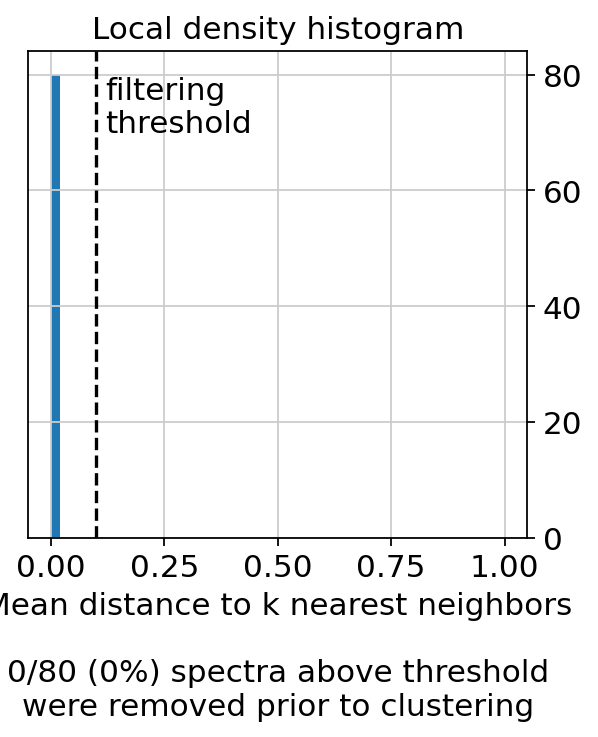

In [67]:
density_filter = cnmf_obj.local_density.iloc[:, 0] < density_threshold
fig, hist_ax = plt.subplots(figsize=(4, 4))

# hist_ax = fig.add_subplot(hist_gs[0,0], xscale='linear', yscale='linear',
#   xlabel='', ylabel='', frameon=True, title='Local density histogram')
hist_ax.hist(cnmf_obj.local_density.values, bins=np.linspace(0, 1, 50))
hist_ax.yaxis.tick_right()

xlim = hist_ax.get_xlim()
ylim = hist_ax.get_ylim()
if density_threshold < xlim[1]:
    hist_ax.axvline(density_threshold, linestyle="--", color="k")
    hist_ax.text(
        density_threshold + 0.02, ylim[1] * 0.95, "filtering\nthreshold\n\n", va="top"
    )
hist_ax.set_xlim(xlim)
hist_ax.set_xlabel(
    "Mean distance to k nearest neighbors\n\n%d/%d (%.0f%%) spectra above threshold\nwere removed prior to clustering"
    % (sum(~density_filter), len(density_filter), 100 * (~density_filter).mean())
)
hist_ax.set_title("Local density histogram")

In [158]:
result_dict = cnmf_obj.load_results(
    K=selected_K, 
    density_threshold=density_threshold,
    n_top_genes=None,
    # n_top_genes=100,
                                    )
result_dict["usage_norm"].head()

,cNMF_1,cNMF_2,cNMF_3,cNMF_4,cNMF_5,cNMF_6,cNMF_7,cNMF_8
1236,0.000000,0.000000,0.000000,0.423153,0.010031,0.187856,0.337421,0.041539
1267,0.000000,0.000000,0.000000,0.221969,0.000000,0.543758,0.226629,0.007643
1292,0.038701,0.085120,0.000000,0.428236,0.000000,0.304437,0.086222,0.057284
1339,0.245253,0.142393,0.049081,0.279886,0.021002,0.028775,0.191105,0.042504
1360,0.297962,0.305731,0.066631,0.000000,0.000000,0.241028,0.000000,0.088648


In [159]:
result_dict["gep_scores"].head()

,1,2,3,4,5,6,7,8
A2M,0.000441,0.003710,-0.001339,-0.001511,-0.000218,-0.001343,-0.001466,-0.000249
AAK1,-0.000045,0.000084,0.000033,-0.000347,-0.000139,0.000100,0.000273,0.000457
ABCA1,-0.000320,0.000309,-0.000167,0.001687,-0.000056,-0.000872,-0.000804,-0.000327
ABCA2,-0.000176,-0.000332,-0.000262,0.000250,0.000118,0.000348,-0.000362,0.001778
ABCA5,-0.000192,-0.000004,0.000076,-0.000077,-0.000100,0.000282,0.000001,0.000390


In [160]:
result_dict["gep_tpm"].head()

,1,2,3,4,5,6,7,8
A2M,676.435180,3566.922997,0.000000,0.000000,224.063930,0.000000,0.000000,64.328244
AAK1,157.194348,203.688626,178.173186,62.864252,121.686114,199.287284,253.861153,400.053289
ABCA1,364.204676,759.193212,473.903670,1656.551134,583.055631,33.455766,82.020872,375.320199
ABCA2,0.000000,0.000000,0.000000,88.040156,62.231019,125.582342,0.000000,716.379011
ABCA5,0.000000,26.238143,33.388395,13.091628,15.883852,73.557451,30.130365,162.904697


In [ ]:
result_dict["top_genes"].to_csv("./tables/31-NMFgene_谱评分_top.csv")
result_dict["top_genes"]

,1,2,3,4,5,6,7,8
0,HLA-DRA,C1QB,IER2,SOD2,CSTB,DNAJB1,S100A8,TRBC2
1,HLA-DQB1,PSAP,EGR1,IL1B,FBP1,HSP90AA1,S100A9,ICOS
2,HLA-DQA1,C1QC,FOS,CCL3L1,SPP1,HSPA1A,FCN1,CD7
3,HLA-DPB1,TMEM176B,JUN,PTGS2,MARCO,BAG3,S100A12,IL32
4,CD74,APOE,FOSB,CXCL8,LPL,HSPH1,VCAN,TIGIT
...,...,...,...,...,...,...,...,...
1816,CTSD,RGCC,APLP2,JUNB,ARL4C,NAMPT,HLA-DPB1,IER3
1817,CCL4,CXCL8,SERPINA1,FTL,SOCS3,PLAUR,CCL4,FTL
1818,CCL3,FOSB,CTSS,TXNIP,MS4A6A,TNFAIP3,CCL4L2,C5AR1
1819,CXCL2,IL1B,LYZ,MT-CO1,NAMPT,HLA-DRB5,RGS1,TYROBP


In [104]:
adata_bak = adata.copy()


In [ ]:

# 自带的的索引不是字符串模式 会出错，转换成str
def get_results(adata, result_dict):
    import pandas as pd

    # 将索引转换为字符串以确保匹配
    adata.obs.index = adata.obs.index.astype(str)
    result_dict["usage_norm"].index = result_dict["usage_norm"].index.astype(str)

    if result_dict["usage_norm"].columns[0] in adata.obs.columns:
        # 删除已存在的列
        adata.obs = adata.obs.loc[:, ~adata.obs.columns.str.startswith("cNMF")]

    # 合并 obs
    adata.obs = pd.merge(
        left=adata.obs,
        right=result_dict["usage_norm"],
        how="left",
        left_index=True,
        right_index=True,
    )

    # 合并 var
    adata.var = pd.merge(
        left=adata.var,
        right=result_dict["gep_scores"].loc[adata.var.index],
        how="left",
        left_index=True,
        right_index=True,
    )

    # 计算最大主题
    df = adata.obs[result_dict["usage_norm"].columns].copy()
    max_topic = df.idxmax(axis=1)

    # 将结果添加到 DataFrame 中
    adata.obs["cNMF_cluster"] = max_topic
    print("cNMF_cluster is added to adata.obs")
    print("gene scores are added to adata.var")



In [124]:
adata = adata_bak.copy()

get_results(adata,result_dict)

adata.obs.loc[:,adata.obs.columns.str.startswith("cNMF")]

cNMF_cluster is added to adata.obs
gene scores are added to adata.var


,cNMF_1,cNMF_2,cNMF_3,cNMF_4,cNMF_5,cNMF_6,cNMF_7,cNMF_8,cNMF_cluster
1236,0.000000,0.000000,0.000000,0.423153,0.010031,0.187856,0.337421,0.041539,cNMF_4
1267,0.000000,0.000000,0.000000,0.221969,0.000000,0.543758,0.226629,0.007643,cNMF_6
1292,0.038701,0.085120,0.000000,0.428236,0.000000,0.304437,0.086222,0.057284,cNMF_4
1339,0.245253,0.142393,0.049081,0.279886,0.021002,0.028775,0.191105,0.042504,cNMF_4
1360,0.297962,0.305731,0.066631,0.000000,0.000000,0.241028,0.000000,0.088648,cNMF_2
...,...,...,...,...,...,...,...,...,...
189602,0.277719,0.130692,0.056084,0.087145,0.004576,0.214018,0.229765,0.000000,cNMF_1
189773,0.465649,0.000890,0.137158,0.088615,0.023068,0.000000,0.266518,0.018103,cNMF_1
190117,0.638154,0.000000,0.226090,0.089966,0.000000,0.000000,0.020278,0.025512,cNMF_1
190158,0.576884,0.083458,0.000000,0.225273,0.000000,0.092090,0.022295,0.000000,cNMF_1


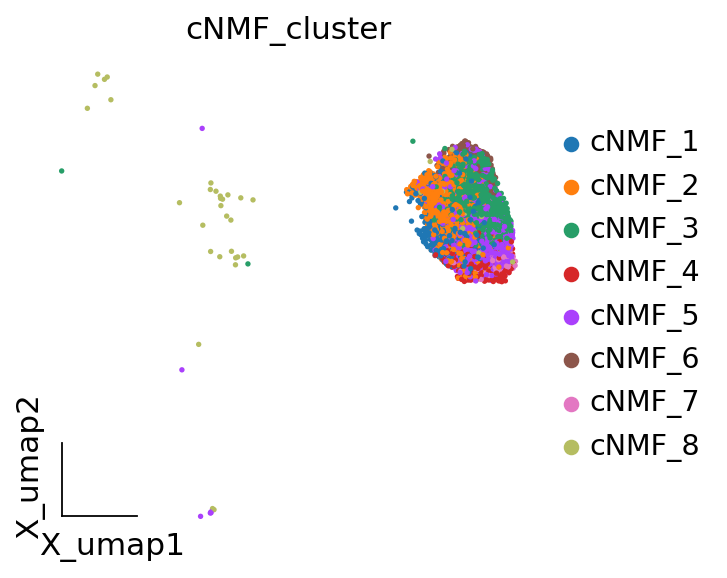

In [128]:
ov.pl.embedding(
    adata,
    basis="X_umap",
    color="cNMF_cluster",
    use_raw=False,
    ncols=3,
    vmin=0,
    vmax=1,
    frameon="small",
)

- 直接用，细胞类型重叠

In [129]:
cnmf_obj.get_results_rfc(
    adata, result_dict, use_rep="scaled|original|X_pca", cNMF_threshold=0.5
)

Single Tree: 0.9362186788154897
Random Forest: 0.979498861047836
cNMF_cluster_rfc is added to adata.obs
cNMF_cluster_clf is added to adata.obs


[<AxesSubplot: title={'center': 'cNMF_cluster_rfc'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <AxesSubplot: title={'center': 'cNMF_cluster_clf'}, xlabel='X_umap1', ylabel='X_umap2'>]

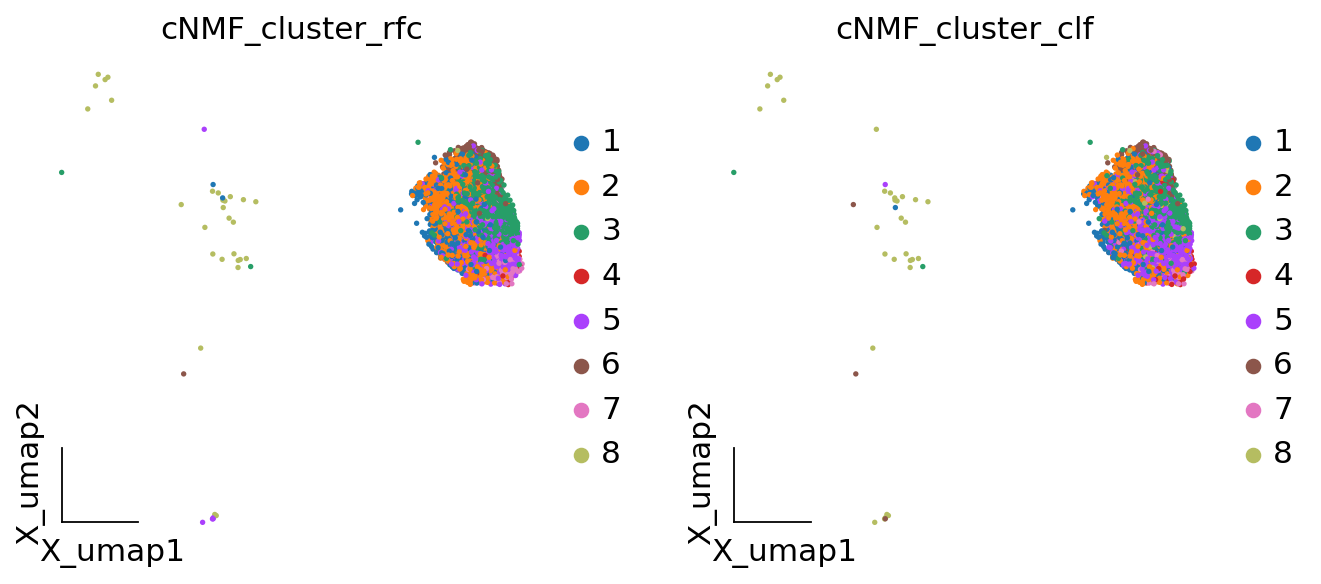

In [131]:
ov.pl.embedding(
    adata,
    basis="X_umap",
    color=["cNMF_cluster_rfc", "cNMF_cluster_clf"],
    frameon="small",
    # title="Celltypes",
    # legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    # size=10,
    # legend_loc=True,
    add_outline=False,
    # add_outline=True,
    outline_color="black",
    outline_width=1,
    show=False,
)

In [132]:
plot_genes = []
for i in result_dict["top_genes"].columns:
    plot_genes += result_dict["top_genes"][i][:5].values.reshape(-1).tolist()

In [133]:
adata.obs["cNMF_cluster"] = adata.obs["cNMF_cluster_rfc"].apply(lambda x: "cNMF_" + x)

In [134]:
ov.pl.embedding(
    adata,
    basis="X_umap",
    color=["cNMF_cluster"],
    frameon="small",
    # title="Celltypes",
    # legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    # size=10,
    # legend_loc=True,
    add_outline=False,
    # add_outline=True,
    outline_color="black",
    outline_width=1,
    show=False,
    save="-cNMF-聚类图.pdf"
)

<AxesSubplot: title={'center': 'cNMF_cluster'}, xlabel='X_umap1', ylabel='X_umap2'>

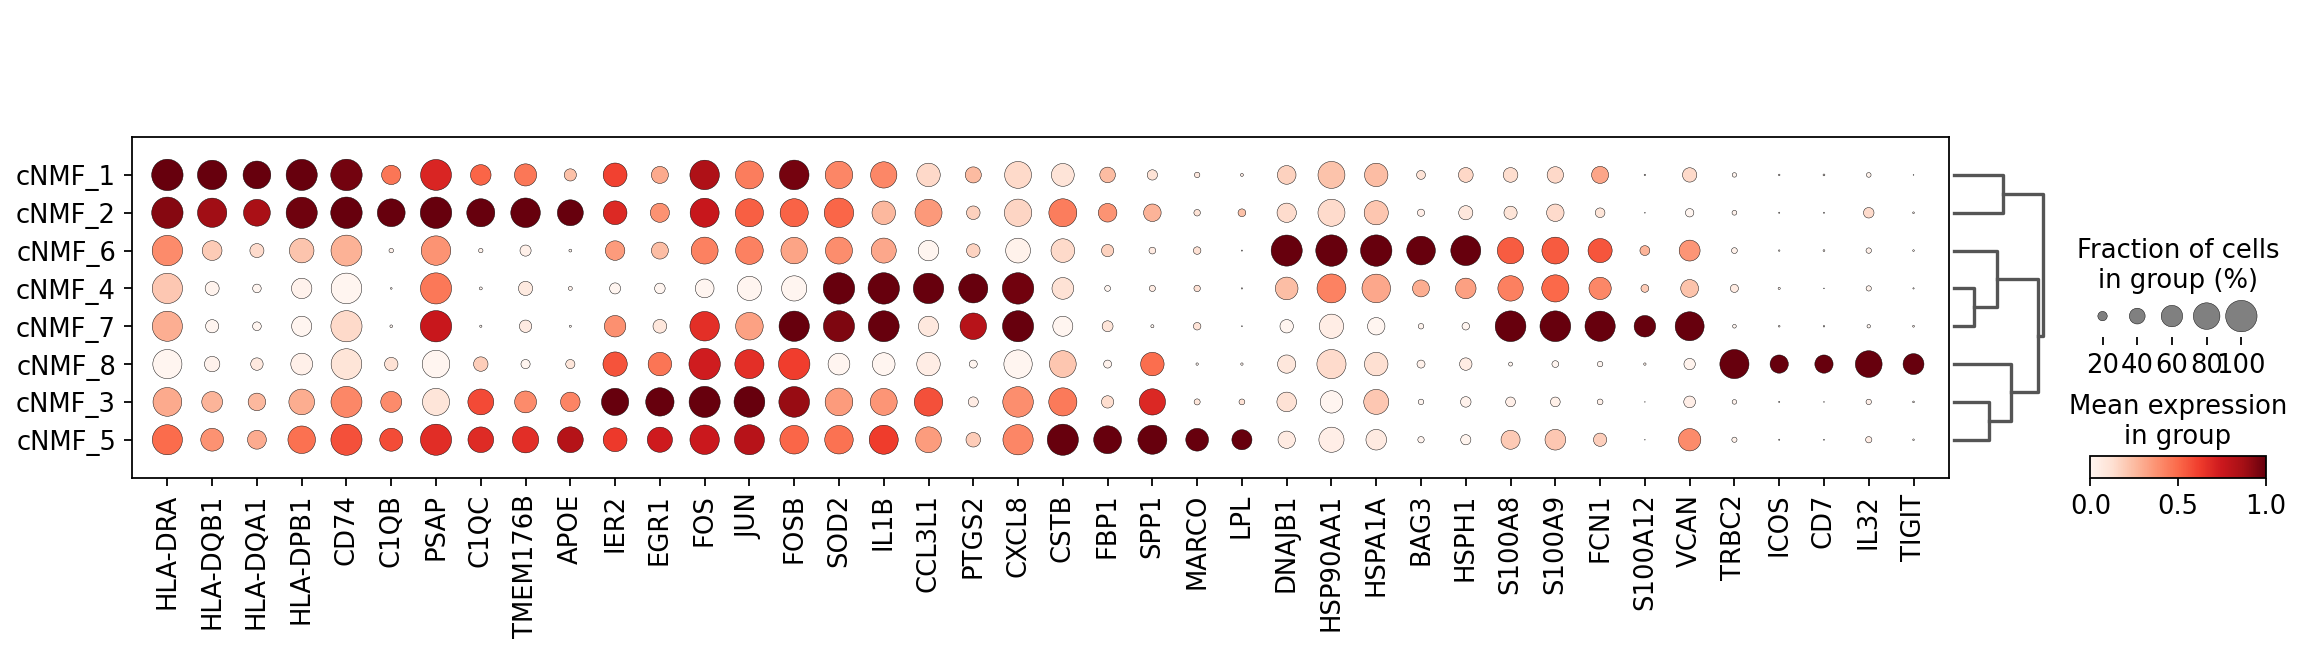

In [157]:
sc.pl.dotplot(
    adata,
    plot_genes,
    "cNMF_cluster",
    dendrogram=True,
    log=True,
    standard_scale="var",
)

In [ ]:
adata.write("sub_anndata_cnmf.h5ad")

In [ ]:
adata = sc.read("sub_anndata_cnmf.h5ad")

In [137]:
GROUP_BY = "cNMF_cluster"

sc.tl.rank_genes_groups(
    adata,
    groupby=GROUP_BY,
    method="t-test",
    use_raw=False,
    layer="lognorm",
)

ranking genes
    consider 'cNMF_cluster' groups:
    with sizes: [1121 1300  521  141  839  759  398   31]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


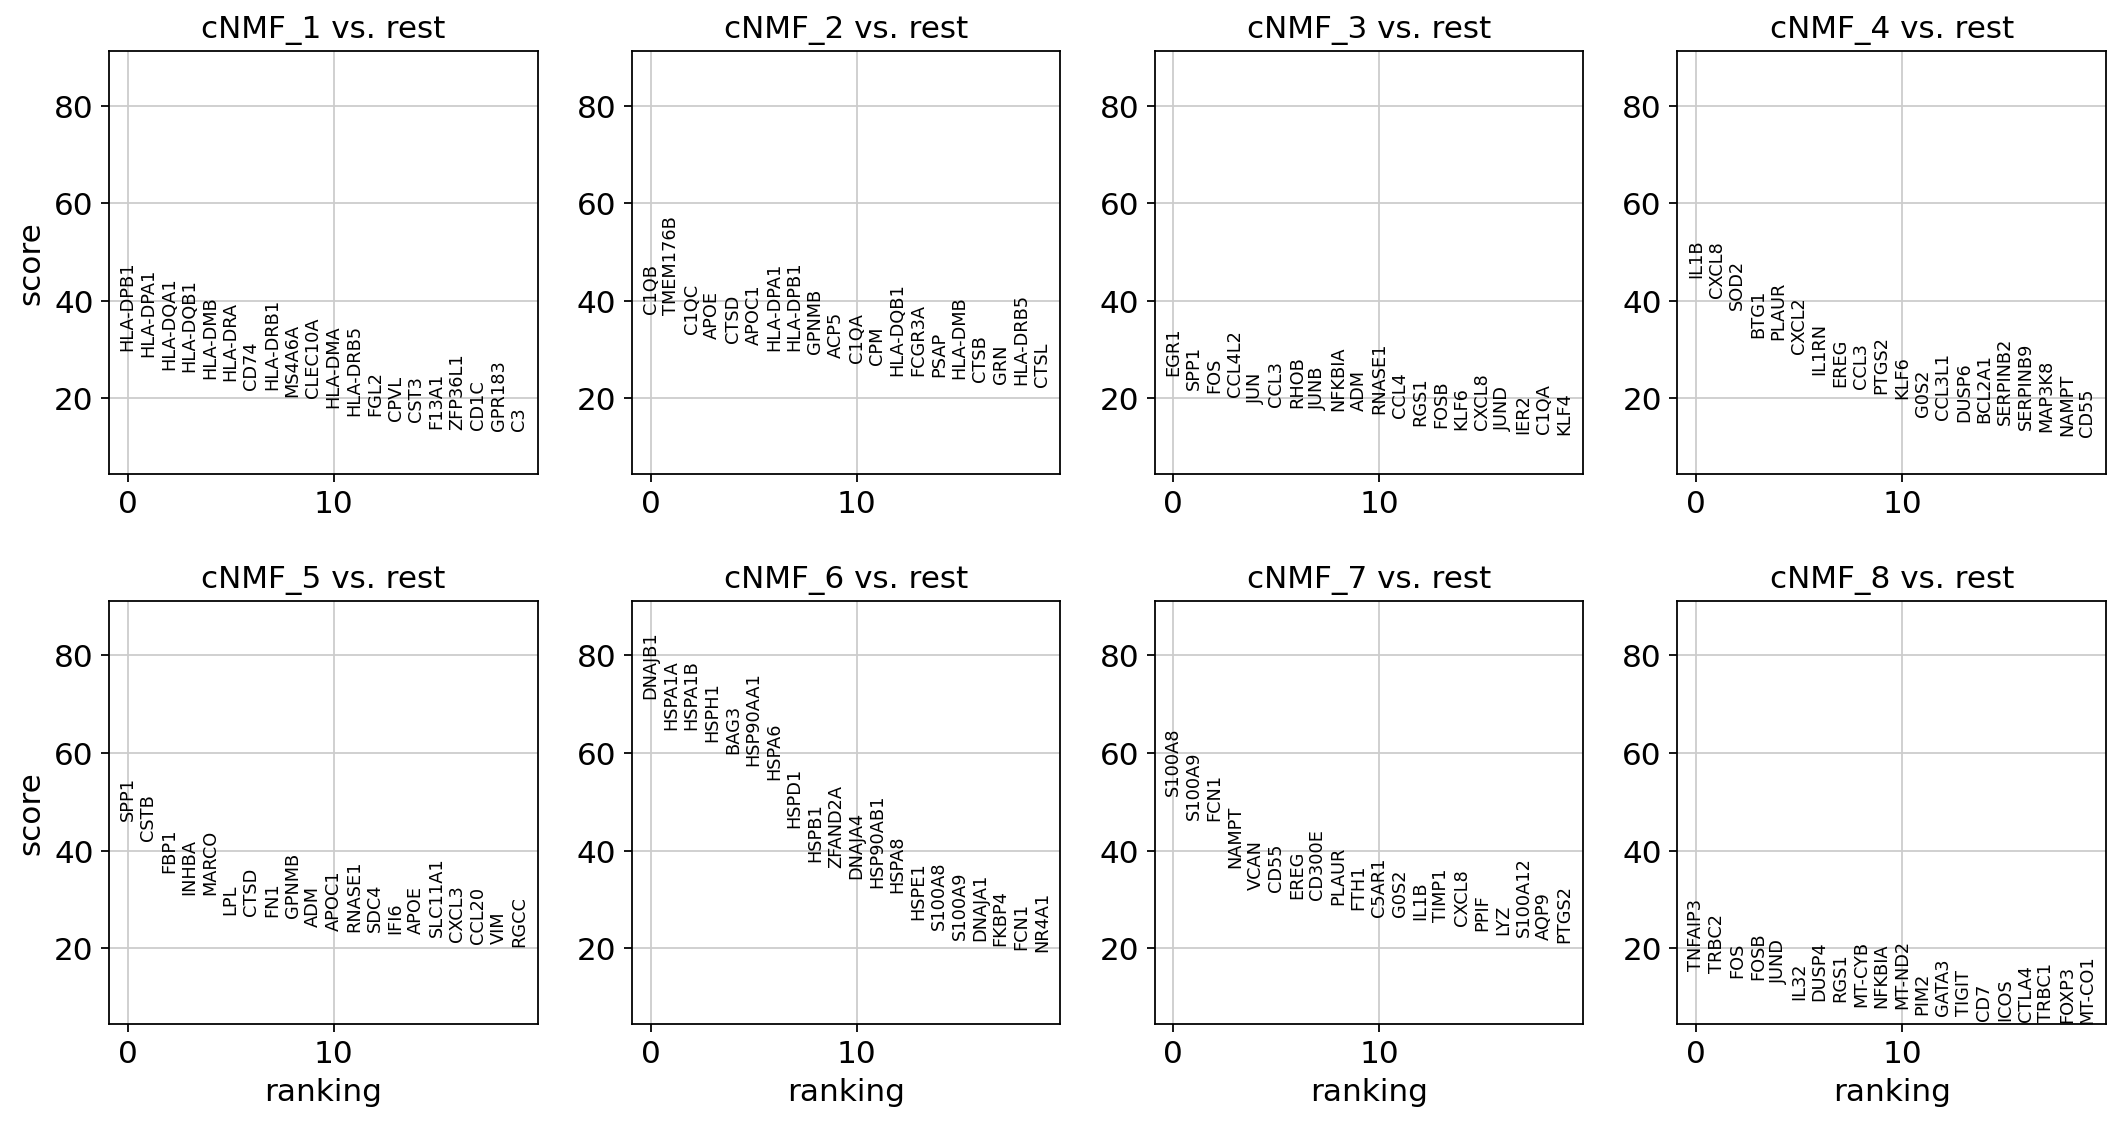

In [138]:
sc.pl.rank_genes_groups(adata, ncols=4)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cNMF_cluster']`


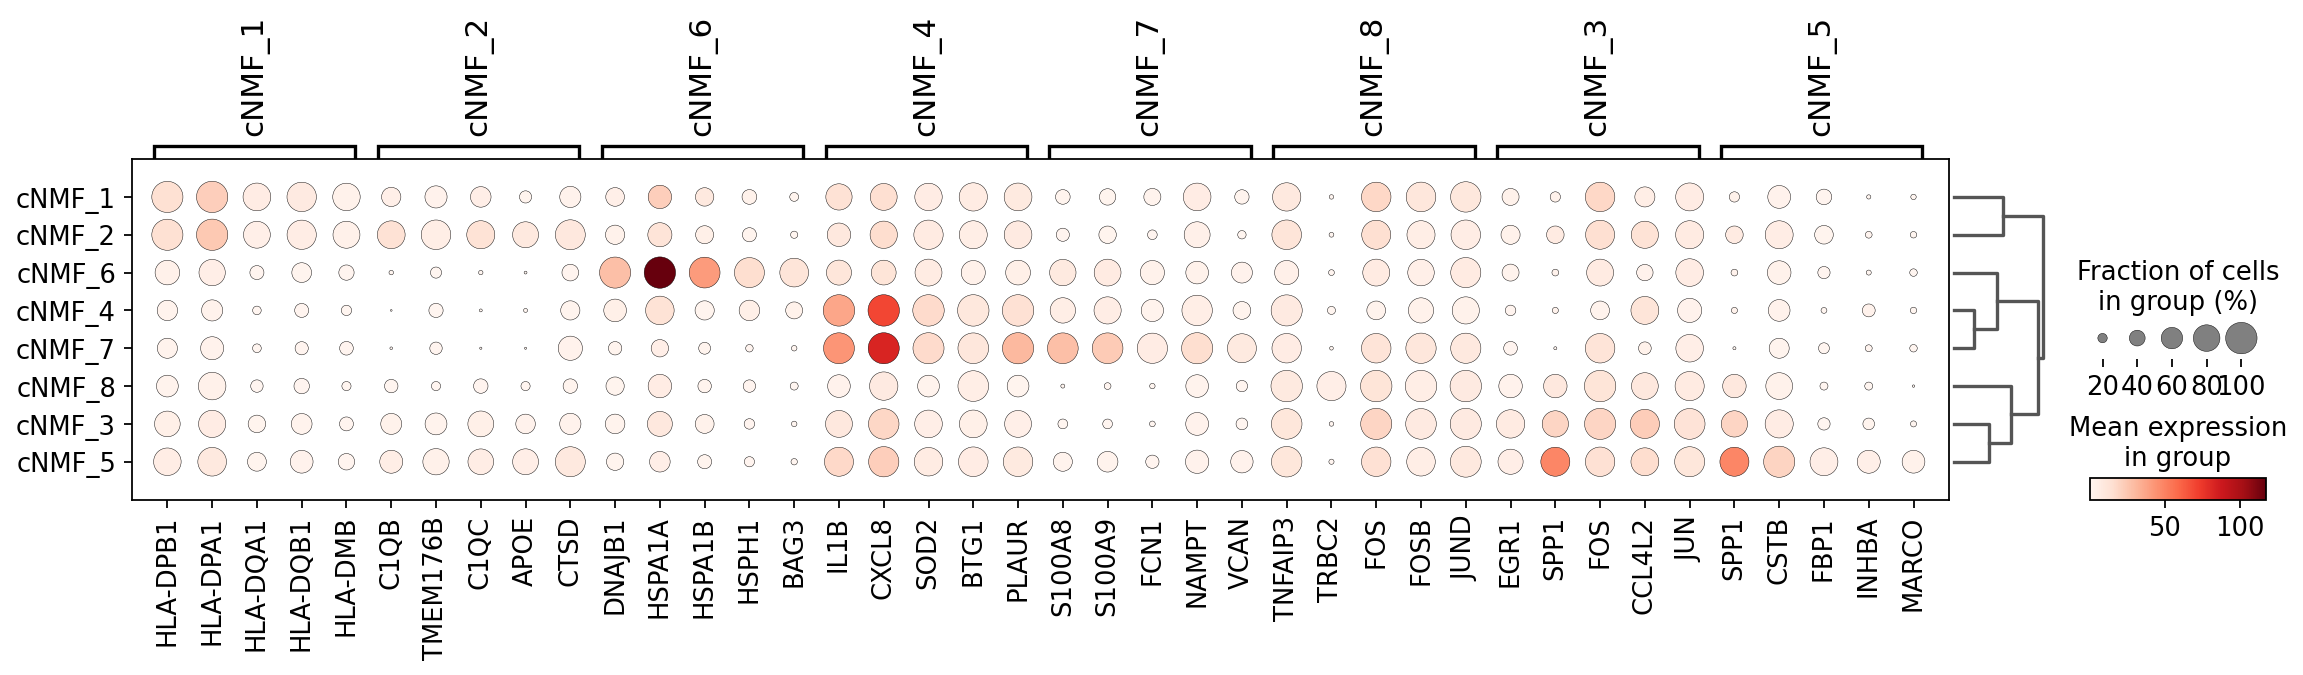

In [139]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=5,
    # vmin=0,
    # vmax=20,
    save="-31-亚群分析-NMF-marker可视化-点图.pdf",
)

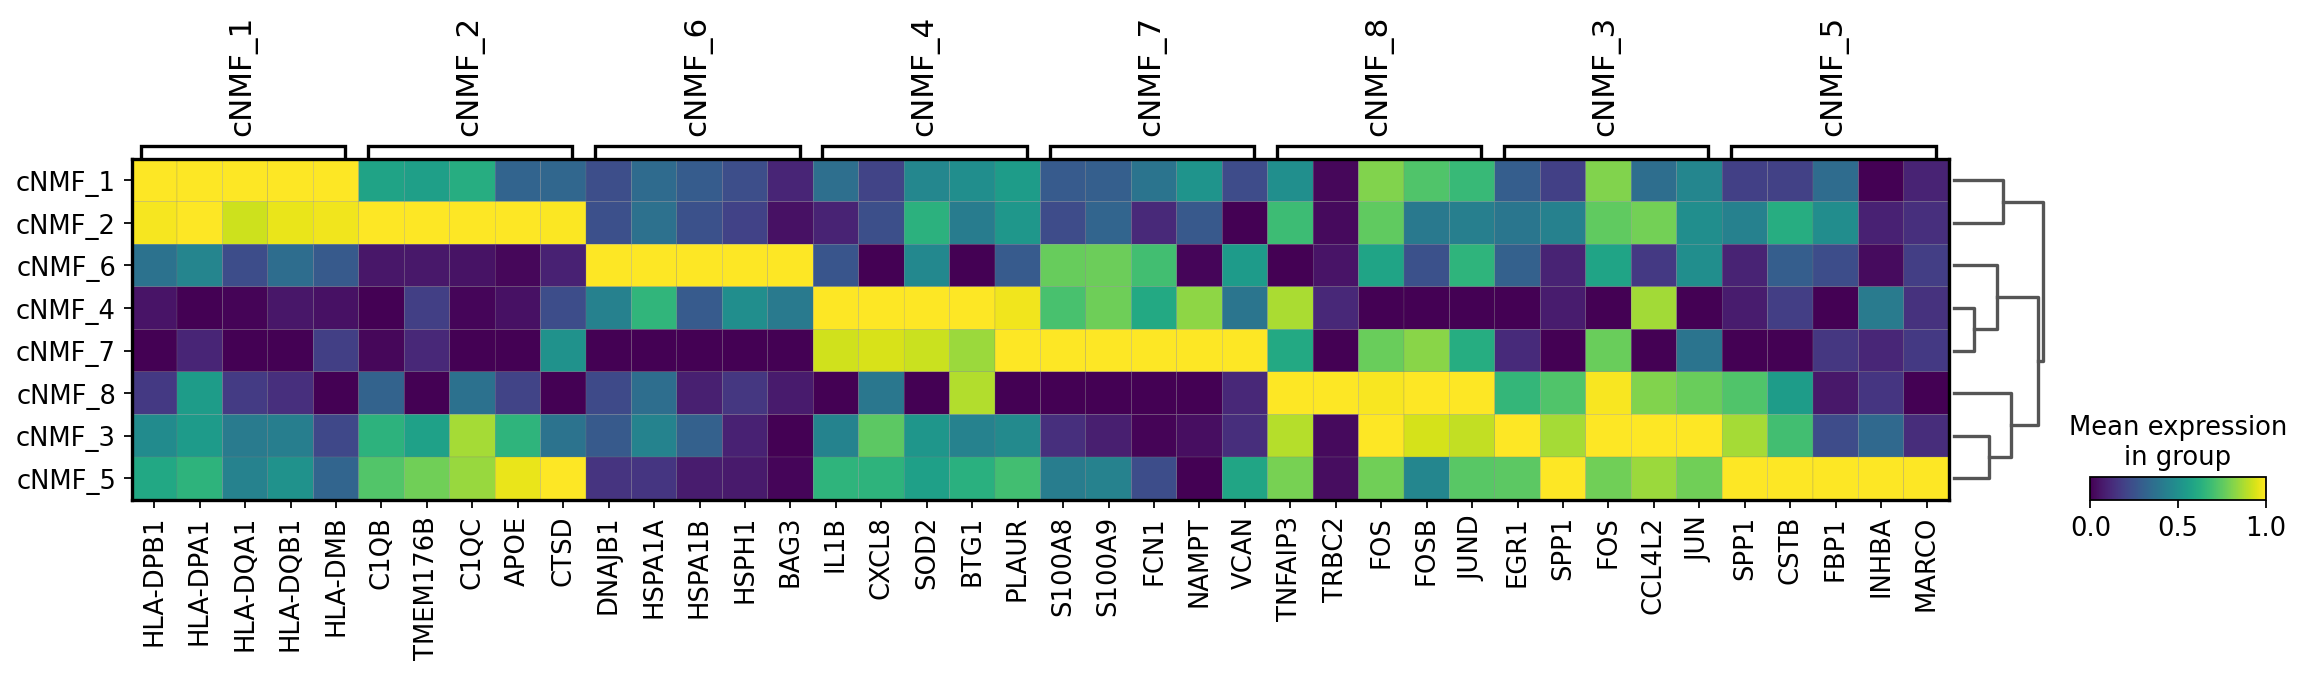

In [140]:
sc.pl.rank_genes_groups_matrixplot(
    adata,
    n_genes=5,
    standard_scale="var",
    use_raw=False,
    save="-31-亚群分析-NMF-marker可视化-热图.pdf",
)

In [141]:
sc.tl.filter_rank_genes_groups(
    adata,
    min_fold_change=1,  # 最小折叠变化阈值
    min_in_group_fraction=0.25,  # 在组内的最小基因表达比例
    max_out_group_fraction=0.5,  # 在组外的最大基因表达比例
    key="rank_genes_groups",  # 基因组数据的键
    key_added="rank_genes_groups_filtered",  # 过滤后的基因组数据的键
    use_raw=False,
)

Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 1, max_out_group_fraction: 0.5


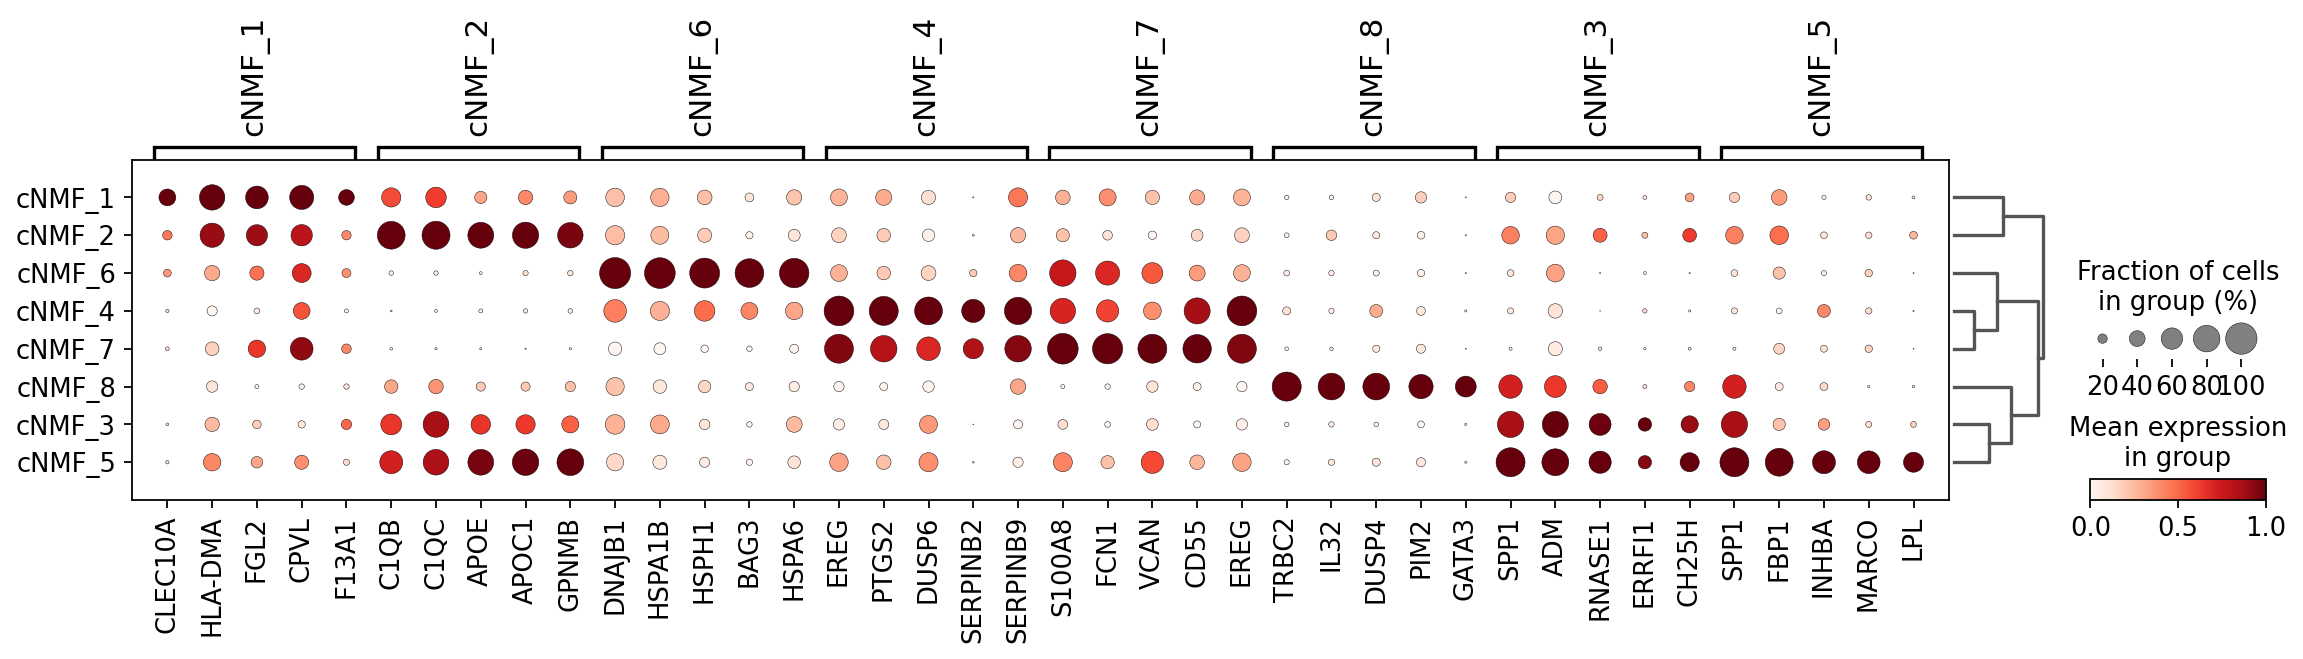

In [143]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby=GROUP_BY,
    standard_scale="var",
    n_genes=5,
    key="rank_genes_groups_filtered",
    save = "-31-亚群分析-NMF-marker可视化-点图-过滤.pdf",
    use_raw=False,
)

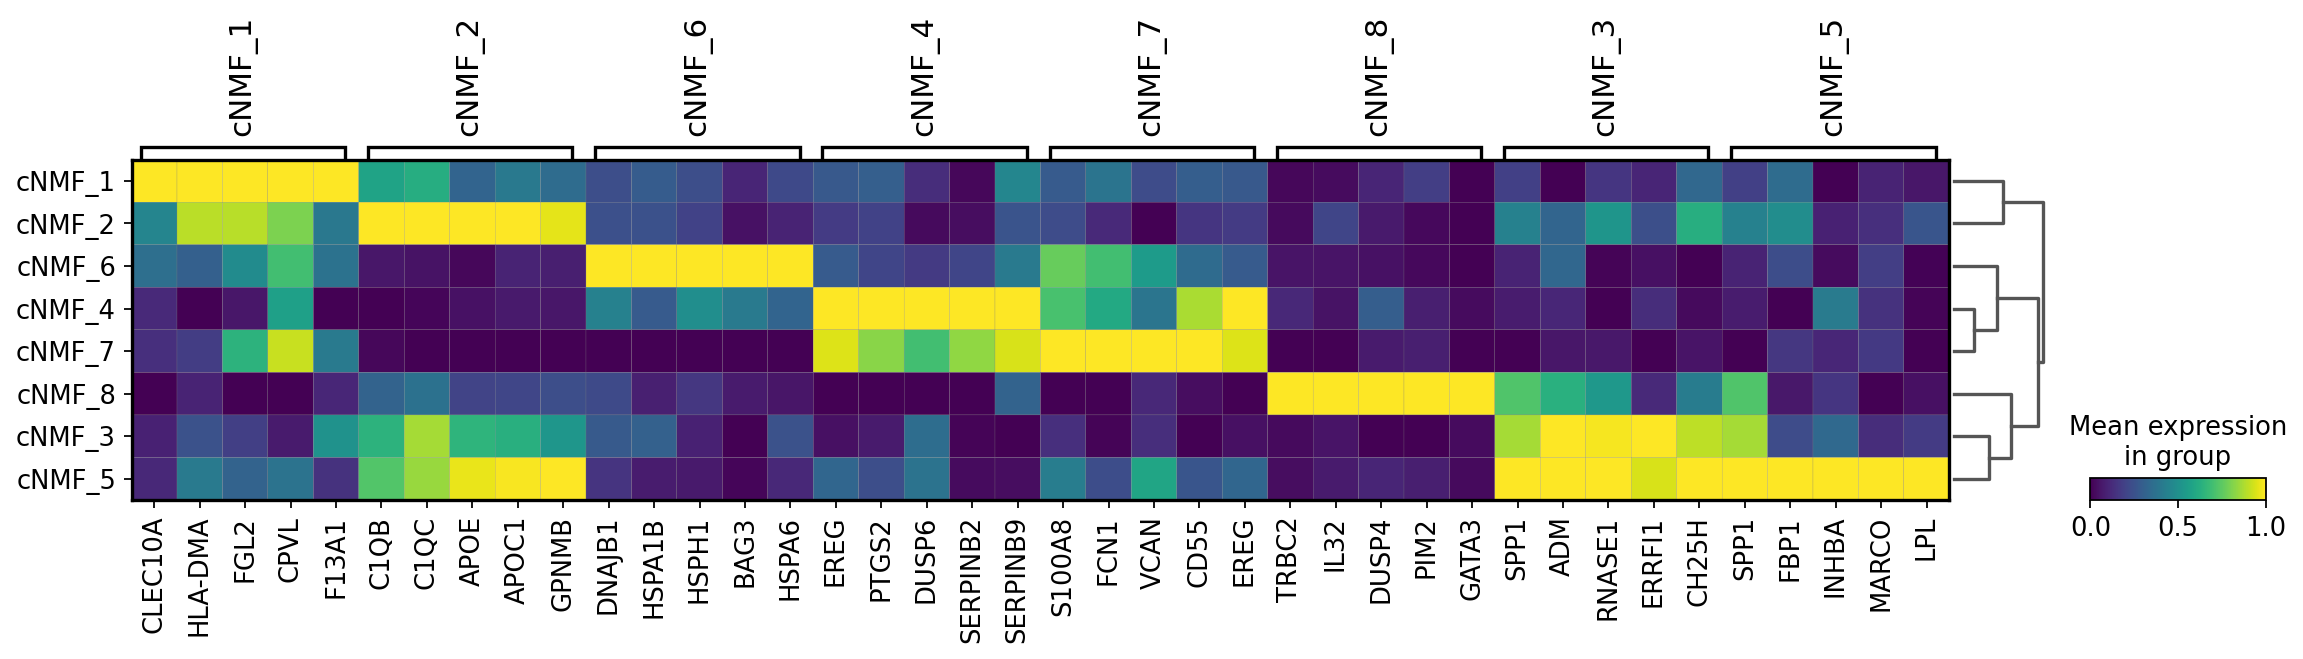

In [144]:
sc.pl.rank_genes_groups_matrixplot(
    adata,
    n_genes=5,
    standard_scale="var",
    key="rank_genes_groups_filtered",
    use_raw=False,
    save = "-31-亚群分析-NMF-marker可视化-热图-过滤.pdf"
)

In [146]:
##  保存全部maker列表

deg_table = sc.get.rank_genes_groups_df(
    adata,
    group=adata.obs[GROUP_BY].unique(),
    key="rank_genes_groups",
)
deg_table = deg_table.dropna(subset=["names"])
deg_table[:5]
deg_table.to_csv("tables/21-all_rank_genes.csv", index=False)

In [147]:
##  保存全部maker列表-过滤后的

deg_table = sc.get.rank_genes_groups_df(
    adata,
    group=adata.obs[GROUP_BY].unique(),
    key="rank_genes_groups_filtered",
)
deg_table = deg_table.dropna(subset=["names"])
deg_table.to_csv("tables/21-all_rank_genes_groups_filtered.csv", index=False)
deg_table[:5]

,group,names,scores,logfoldchanges,pvals,pvals_adj
9,cNMF_1,CLEC10A,20.275465,4.085725,2.852636e-80,4.328876e-78
10,cNMF_1,HLA-DMA,18.175449,2.975450,1.943570e-68,2.081906e-66
12,cNMF_1,FGL2,16.401758,2.900117,1.872619e-56,1.550018e-54
13,cNMF_1,CPVL,15.459430,2.649628,6.959449e-51,4.874291e-49
15,cNMF_1,F13A1,13.873666,2.697148,2.700011e-41,1.586039e-39


## 看看在那个亚群咋们的bulkgene最牛


## 免疫因子富集分析

In [151]:
import pandas as pd

sheet_dict = pd.read_excel(
    "/home/fanxi/projects/snakemake/snakemake-single-cell/resources/41586_2023_6816_MOESM5_ESM.xlsx",
    sheet_name=None,
)
cytokine_responses = pd.concat(sheet_dict.values()).reset_index(drop=True)

cytokine_responses_cell = "Macrophage"

celltype_response = cytokine_responses.query(
    f"Celltype_Str == '{cytokine_responses_cell}'"
).copy()

celltype_response["Gene"] = celltype_response["Gene"].map(lambda s: [s])
response_sets = celltype_response.groupby(["Cytokine"])["Gene"].sum().to_dict()
print(response_sets)

{'CT-1': ['Ccl9', 'Wfdc17', 'Ccl12', 'Ccl6', 'Saa3', 'Ccl7', 'Ifitm2', 'Cxcl9', 'Pnp', 'Fcgr2b', 'Ifi204', 'Mt1', 'Steap4', 'Fcgr3', 'Clec4n', 'Isg15', 'Hmox1', 'Msrb1', 'Dok2', 'Fcgr1', 'Eif4a1', 'Scimp', 'Tmem268', 'Psma3', 'Ptpn1', 'Osgin1', 'Cox7a2l'], 'Decorin': ['Mettl21a'], 'EGF': ['Ccl9'], 'GM-CSF': ['Ccl9', 'Ccl12', 'Ccl2', 'Ccl7', 'Ccl6', 'Bcl2a1b', 'Lpl', 'Il1b', 'Serpina3g', 'Clec4n', 'Nabp1', 'Sdc4', 'Prkcd', 'Bcl2a1a', 'Atp6v1b2', 'Cd209e', 'Bcl2a1d', 'Ncl', 'Glrx', 'Srm', 'Cdkn1a', 'Plek', 'Tma16', 'Eif4a1', 'Basp1', 'Ranbp1', 'Eif5a', 'Riok3', 'Ran', 'Dok2', 'Ptpn1', 'Set', 'Tubb6', 'Serbp1', 'Mrpl11', 'Gtpbp4', 'Eef1e1', 'Anp32b', 'Odc1', 'Bax', 'Atp6v0a1', 'Imp4', 'Scimp', 'Lrrc59', 'Eif4g2', 'Palld', 'Nlrp3', 'Pfn1', 'Fth1', 'Epsti1', 'Cox7a2l', 'Gngt2', 'Rgs10', 'Igkc', 'Sat1', 'Syndig1l', 'Dhrs1', 'Tmem86a'], 'IFN-α1': ['Cxcl10', 'Isg15', 'Ccl12', 'Rsad2', 'Cxcl9', 'Serpina3g', 'Irf7', 'Ifit2', 'Cmpk2', 'Pnp', 'Ifit3', 'Ccl7', 'Ifitm3', 'Ccl2', 'Ifi204', 'Ifi47', '

In [152]:
SUB_TYPE = "cNMF_6"
rank_gene = deg_table.loc[deg_table[GROUP_COL] == SUB_TYPE, :].iloc[:, 1:3]
rank_gene.columns = ["gene_name","rnk"]
rank_gene.head()

,gene_name,rnk
9105,DNAJB1,71.224022
9107,HSPA1B,64.747459
9108,HSPH1,62.377975
9109,BAG3,59.896755
9111,HSPA6,54.656609


In [153]:
gsea_obj = ov.bulk.pyGSEA(rank_gene, response_sets, cutoff=1,outdir=f"./enrichr_gsea-{SUB_TYPE}")

In [154]:
response_sets.keys()

dict_keys(['CT-1', 'Decorin', 'EGF', 'GM-CSF', 'IFN-α1', 'IFN-β', 'IFN-γ', 'IFN-ε', 'IFN-κ', 'IL-10', 'IL-11', 'IL-12', 'IL-13', 'IL-15', 'IL-17F', 'IL-18', 'IL-1α', 'IL-1β', 'IL-2', 'IL-21', 'IL-24', 'IL-27', 'IL-3', 'IL-31', 'IL-33', 'IL-36Ra', 'IL-36α', 'IL-4', 'IL-5', 'IL-7', 'LIF', 'Leptin', 'M-CSF', 'OSM', 'PRL', 'PSPN', 'RANKL', 'SCF', 'TGF-β1', 'TNF-α', 'TPO'])

In [155]:
rank_gene["rnk"] = rank_gene["rnk"].astype(float)

In [156]:
enrich_res = gsea_obj.enrichment()

2024-11-03 22:50:27,443 [ERROR] No gene sets passed through filtering condition!!!, try new parameters again!
Note: check gene name, gmt file format, or filtering size.


Exception: No gene sets passed through filtering condition

In [ ]:
import pandas as pd

res_2d = pd.read_csv(f"./enrichr_gsea-{SUB_TYPE}/gseapy.gene_set.prerank.report.csv")
res_2d

In [ ]:
import networkx as nx
import gseapy as gp

In [ ]:
nodes, edges = gp.enrichment_map(res_2d)  # 默认按照Adjusted P-value过滤0.05

In [ ]:
G = nx.from_pandas_edgelist(
    edges,
    source="src_idx",
    target="targ_idx",
    edge_attr=["jaccard_coef", "overlap_coef", "overlap_genes"],
)

# Add missing node if there is any
for node in nodes.index:
    if node not in G.nodes():
        G.add_node(node)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))

# init node cooridnates
pos = nx.layout.spiral_layout(G)
# pos = nx.layout.spring_layout(G, seed=42)
# node_size = nx.get_node_attributes()
# draw node
nx.draw_networkx_nodes(
    G,
    pos=pos,
    cmap=plt.cm.RdYlBu,
    node_color=list(nodes.NES),
    node_size=list(nodes.Hits_ratio * 1000),
    alpha=0.5,
)
# draw node label
nx.draw_networkx_labels(G, pos=pos, labels=nodes.Term.to_dict())
# draw edge
edge_weight = nx.get_edge_attributes(G, "jaccard_coef").values()
nx.draw_networkx_edges(
    G, pos=pos, width=list(map(lambda x: x * 10, edge_weight)), edge_color="green",alpha=0.2
)
# 去掉坐标轴
plt.axis("off")
plt.savefig(f"./figures/31-亚群分析-NMF-免疫GSEA富集分析-网络图-{SUB_TYPE}.pdf")
plt.show()